## This is an Example of Using Markdown Cells
Markdown cells can be inserted anywhere within your notebook and are useful for documenting what you are doing.  Since markdown is a superset of HTML, you can use HTML and CSS (cascading style sheets) in these cells too.

### Adding a Markdown cell 
When you want to add a markdown cell, just insert a cell by selecting to insert above or below the current cell by first selecting `Insert` from the menu (you will need to be in edit mode).<br>
Once you add a cell, with that cell selected (the left border is blue), select `Cell`, then `Cell Type`, and then `Markdown` from the menu.  You can also select the type of cell from the Format drop-down list in the menu bar:

<div style="width:300px;left:0px;margin:5px;">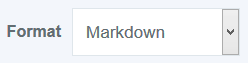</div>

When you run a markdown cell, Jupyter will use the markdown you entered to create HTML that is displayed.  This allows you to create more readable documentation including pictures.  An image can be included from the URL to a website, but you can also embed pictures directly in a markdown cell as we did above for the Format drop-down list.  In that case we did a screen capture of the snippet of the screen that we wanted and saved it to a png file on our laptop.  We then right-clicked on the file, selected copy, and then pasted it into this markdown cell where we wanted it to appear (on its own line).  Our file was named "MarkdownFormat.PNG", so when we pasted it into this cell, the following code was added by Jupyter:

```
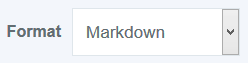
```

If you do no other formatting, the image inserted will be centered on the page.  Since we wanted the images to appear on the left, we wrapped the the above code in an HTML `div` tag (you will need to play with the `width` in the `div` tag to get it to display at the size and position you want):

```
<div style="width:300px;left:0px;margin:5px;">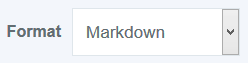</div>
```

You will notice that wne you are in a markdown cell, there are no square brackets to the left of the cell since markdown is not code that is executed.  If you want to edit your markdown cell, then with that cell highlighted, select `Code` as the Format for the cell from the drop-down list and then select `Markdown` again from the drop-down list.  The cell will then be editable until you run that cell again.

### Loading Data 
In this notebook we will run through some examples of using Spark SQL, but first we need to load some data.  In the cell below, you will see that we are creating a DataFrame named `df_reviews`, which is based on the variable `review_path`.  With the Yelp review data as one of the Data Assets in your project, insert the code for your credentials and to load the review data by selecting `Insert SparkSession DataFrame` from the `Insert to code` drop-down list for the review data file on the right-hand side.  If the file list is not visible, click on the green icon with the 1's and 0's on the upper right-hand side:

<div style="width:100px;left:0px;margin:5px;">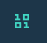</div>

This is the `Find and Add Data` feature.

When you insert the code, it will add a line at the end similar to the following:
``` 
path_1 = bmos.url('Fall2017', 'review.json.gz')
```
The first parameter is your container name (by default the same as your project name) and the second parameter is obviously the name of the review data file. DSX may assign some other variable name to the path other than 'path_1', but whatever name it assigns, replace that with 'review_path'.

In [2]:

import ibmos2spark

# @hidden_cell
credentials = {
    'auth_url': 'https://identity.open.softlayer.com',
    'project_id': '8aa6e0aab6094fdd9838d3e08e7253f3',
    'region': 'dallas',
    'user_id': '775a8781e7bf4c0b88ebc086525aa3d7',
    'username': 'member_78415bb429eb12ae25686a6d27742576ced7a7ca',
    'password': 'IJ3.9-K=12.]s&r?'
}

configuration_name = 'os_fa1cd21c20344b08a7e27d96dc1f7387_configs'
bmos = ibmos2spark.bluemix(sc, credentials, configuration_name)

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
# Please read the documentation of PySpark to learn more about the possibilities to load data files.
# PySpark documentation: https://spark.apache.org/docs/2.0.1/api/python/pyspark.sql.html#pyspark.sql.SparkSession
# The SparkSession object is already initalized for you.
# The following variable contains the path to your file on your Object Storage.
review_path = bmos.url('Fall2017', 'review.json.gz')


In [3]:



df_reviews = spark.read.json(review_path)

## Working With Date Fields
The following examples use Spark SQL to run queries against a temporary view when using date functions.

The dates in the Yelp data are of the format YYYY-MM-DD such as 2016-10-31 for Halloween in the year 2016.

### Where Dates are Used in the Yelp Data:

<b>Review Data:</b> The “date” field has the date of the review, which you may want to use as a rough proxy for when a user went to a business, but keep in mind that it is not the exact date they went to the business.  This is the date they posted their review.

<b>User Data:</b> The “yelping_since” field has the date a user joined Yelp.

<b>Tip Data:</b> The “date” field has the date of the tip (which you may also want to use as a rough proxy for when a user went to a business).  Why might this date be closer to the actual date of the user’s visit than the review date?  What is different about tips and reviews?

A temporary view named `yelp_reviews` is created for the queries.  The record count for the reviews data and the schema that Spark infers for the review data is also shown.  The `count()` function when run on a DataFrame returns the number of records.  Here we are using the Python `print` function to print that count.  The `print` function takes a comma-separated list of values.

Each of the queries returns a DataFrame and the first 20 rows are shown using the show() function.  If you are using this in a project, you would want to assign the result to a DataFrame and then call show on that DataFrame.  If you are using `show()` with one of the Yelp id fields (such as `business_id`, `user_id`, or `review_id`), you may want to use `show(truncate=False)` which means that for long text fields such as the ID fields Spark will not truncate them when showing them.  If you use this option, be sure the `F` in `False` is capitalized or it won't work.


In [5]:
print"Number of review records:", df_reviews.count()
df_reviews.printSchema()
df_reviews.createOrReplaceTempView('yelp_reviews')

 Number of review records: 4736897
root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: long (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)



## Getting the year from the review date field

There is a `Year()` function in SQL that will get the year from a date field.  You may be wondering if the date field in the review is of a date data type since the inferred schema shows it as a string.  When we use any of the date functions on that field, Spark will try to cast it as a date (meaning change it's data type to a date), which it can since the review date is in the format yyy-mm-dd.

In the following query, we are going to count how many reviews occurred in each year.  We are going to GROUP BY the `YEAR(date)` which is the year in our date field and then ORDER BY that value also.  However for the ORDER BY clause we can use the alias we gave to `YEAR(date)` in the SELECT clause since when we reach the ORDER BY clause we have already selected the data and the column is known as `review_year`.  When writing the query, the back slashes are just line continuations - a way of saying this continues on the next line.  

Here we are limiting the year to those before 2017 because we only have hafl of 2017's data in Round 10 of the Yelp Dataset Challenge.  Whether to include 2017 depends on your question - are you comparing years?

In [8]:
df_reviews_full_years = spark.sql("SELECT YEAR(date) AS review_year, COUNT(review_id) AS total_reviews \
FROM yelp_reviews \
WHERE YEAR(date) < 2017 \
GROUP BY YEAR(date) \
ORDER BY review_year")
df_reviews_full_years.show()

+-----------+-------------+
|review_year|total_reviews|
+-----------+-------------+
|       2004|           14|
|       2005|          866|
|       2006|         5642|
|       2007|        22895|
|       2008|        61093|
|       2009|        97834|
|       2010|       185643|
|       2011|       287814|
|       2012|       345637|
|       2013|       468608|
|       2014|       670440|
|       2015|       897835|
|       2016|      1033124|
+-----------+-------------+



### Showing a simple graph of the reviews by year

From the above results we can see that 2004 (the first year for Yelp) did not generate a lot of reviews in the 11 cities in the dataset, but the number has grown over time.  Wow, there was a huge drop in reviews in 2017!   That's a bit misleading since we are using Round 10 which was pulled in the middle of 2017.  Maybe we should change our query to only include years prior to 2017.

It would be nice to see this as a simple graphic such as a bar or line graph.  Python has a module known as `matplotlib` that will allow us to do that using a function named `pyplot`.  To use that function we need to import it from it's module.  It has one other requirement, instead of rows, pyplot requires a list, so our review list column needs to look like the following:
```
[2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016]
```
We can do this by calling the `collect()` function on a DataFrame that has one column. Since our DataFrame has 2 columns, we need to first call the `select` function to get each column separately. 

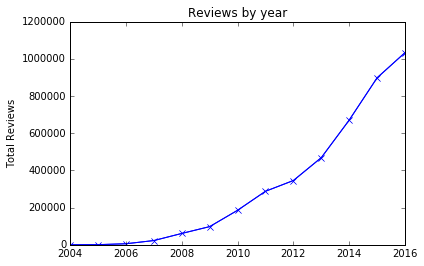

In [12]:
from matplotlib import pyplot as plt
years_list=df_reviews_full_years.select("review_year").collect()
reviews_list=df_reviews_full_years.select("total_reviews").collect()
plt.plot(years_list, reviews_list, color='blue', marker='x', linestyle='solid')
plt.title('Reviews by year')
plt.ylabel('Total Reviews')
plt.show()



### Line chart options

As you may have noticed, the pyplot takes a while to plot, but if you are trying to get a quick idea for purpose of profiling your data, you can do this from within Spark without taking your results out to Tableau or some similar visualization package (although you would want to do that for your final result).

In the above chart we drew the line on the graph with the following code:

``` python
plt.plot(years_list, reviews_list, color='blue', marker='x', linestyle='solid')
```

This drew a solid line, but other options are: `dash`, `dot`, `dashdot`

What if we had multiple lines we wanted to draw?

As an example, what if we also wanted to plot the total numer of tips for each year?  In that case we could load the tip data file and use Spark SQL to calculate the total tips for each year as we did for the reviews.  

In [14]:

# Please read the documentation of PySpark to learn more about the possibilities to load data files.
# PySpark documentation: https://spark.apache.org/docs/2.0.1/api/python/pyspark.sql.html#pyspark.sql.SparkSession
# The SparkSession object is already initalized for you.
# The following variable contains the path to your file on your Object Storage.
tips_path = bmos.url('Fall2017', 'tip.json.gz')


In [15]:
df_tips=spark.read.json(tips_path)

In [16]:
print"Number of tips records:", df_tips.count()
df_tips.printSchema()
df_tips.createOrReplaceTempView('yelp_tips')

Number of tips records: 1028802
root
 |-- business_id: string (nullable = true)
 |-- date: string (nullable = true)
 |-- likes: long (nullable = true)
 |-- text: string (nullable = true)
 |-- user_id: string (nullable = true)



In [17]:
df_tips_full_years = spark.sql("SELECT YEAR(date) AS tips_year, COUNT(business_id) AS total_tips \
FROM yelp_tips \
WHERE YEAR(date) < 2017 \
GROUP BY YEAR(date) \
ORDER BY tips_year")
df_tips_full_years.show()

+---------+----------+
|tips_year|total_tips|
+---------+----------+
|     2009|       919|
|     2010|     40646|
|     2011|    142051|
|     2012|    180096|
|     2013|    162222|
|     2014|    159086|
|     2015|    126885|
|     2016|    136422|
+---------+----------+



We then want to plot the years and totals for the tips on the same graph as our reviews, and we already have the years and total reviews as lists, so we create lists for the years and totals for tips.

To then plot the reviews and tips on the same graph we call the `plot` function, but for multiple lines we specify 3 parameters for each line:  the x-axis, the y-axis, and a format string.  In our first graph we specified the line color, line style, and marker, but for multiple lines, the color, style, and marker are specified as a "format group" for each line using the following short-hand:

|line style description | line style code | color name | color code | marker description | marker code|
|-----------------------|-----------------|------------|------------|--------------------|------------|
| solid                 |  '-'            |  blue      | 'b'        | circle             | 'o'        |
| dashed                |  '--'           |  green     | 'g'        | triangle down      | 'v'        |
| dash-dot              |  '-.'           |  red       | 'r'        | triangle up        | '^'        |
| dotted                |  ':'            |  cyan      | 'c'        | square             | 's'        |
|                       |                 |  magenta   | 'm'        | pentagon           | 'p'        |
|                       |                 |  yellow    | 'y'        | star               | '*'        |
|                       |                 |  black     | 'k'        | hexegon            | 'h'        |
|                       |                 |  white     | 'w'        | diamond            | 'D'        |

For the reviews line we will use the format group `'-bo'` for a solid blue line with circle markers and for the tips line we will use the format group `'-.rD'` for a red dash-dot line with diamond markers.

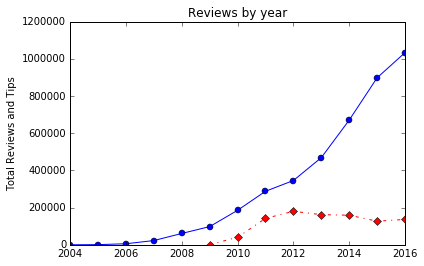

In [20]:
tips_year_list=df_tips_full_years.select("tips_year").collect()
tips_list=df_tips_full_years.select("total_tips").collect()
plt.plot(years_list, reviews_list,'-bo',tips_year_list, tips_list, '-.rD')
plt.title('Reviews and Tips by year')
plt.ylabel('Total Reviews and Tips')
plt.show()
